In [1]:
import json, requests, os, time, scipy
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader

from dGbyG.config import *
from dGbyG.utils.constants import *
from dGbyG.utils.ChemFunc import *
from dGbyG.utils.custom_tools import rapid_process_result, rapid_linear_reg
from dGbyG.Chemistry.Reaction import Reaction
from dGbyG.network.GNNetwork import MP_network
from dGbyG.network.Dataset import Train_Dataset
from dGbyG.train.trainer import Model
from dGbyG.api.inference import Compound

In [2]:
trainingData_df = pd.read_csv(train_data_path)

mean_std = trainingData_df.loc[:,'stderr'].mean()
SEM = np.nan_to_num(trainingData_df.loc[:,'SEM'], nan=mean_std)
weight = (1/(SEM+1))/np.median((1/(SEM+1)))
trainingData_df.loc[:,'weight'] = weight

TrainSet = Train_Dataset(trainingData_df, equation_column='reaction', dG_column='standard_dg_prime', weight_column='weight')

network = MP_network(emb_dim=300, num_layer=2)

model = Model()
model.network = network

In [3]:
Loss, Result_df = model.cross_validation(TrainSet, mode=10, epochs=9000, lr=1e-4, weight_decay=1e-6)

Cross validation. Start at:2023-07-12 21:35:31
train on: cuda:0
Mode: K-fold validation. K = 10


fold 9: 100%|██████████| 9000/9000 [01:04<00:00, 140.02it/s]


Cross validation. End at: 2023-07-12 21:47:11


epochs: 9000
Median Absolute Error: 3.8120014667510986
Mean Absolute Error: 8.520753602462912
Min_loss: 8993 21.578236


Min_mae: 8984 3.737548828125


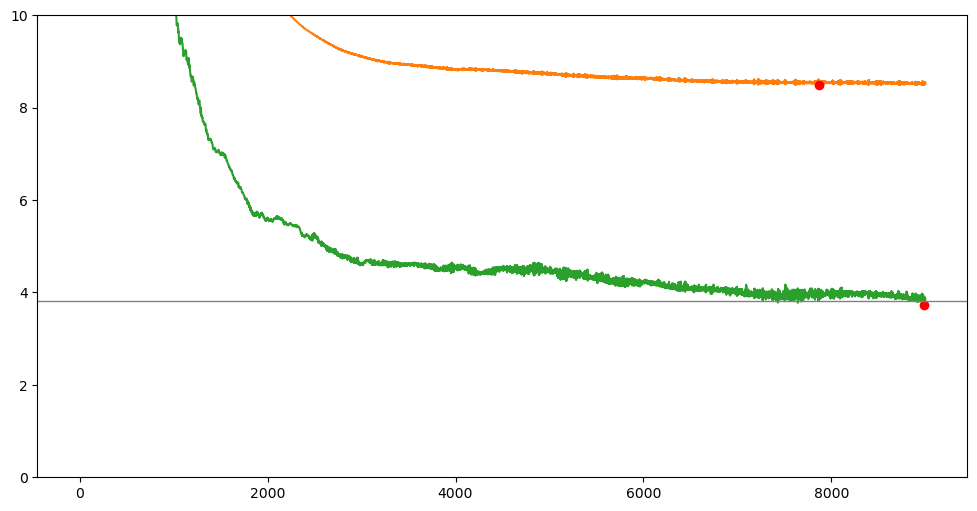

In [4]:
r, final_p, final_ae = rapid_process_result(Loss, Result_df, path=False, plot=True)

The linear model is: Y = -1.2509 + 0.9951X
PearsonRResult(statistic=0.9976707531386324, pvalue=0.0)
SignificanceResult(statistic=0.9144468425249406, pvalue=1.3535976810037734e-266)


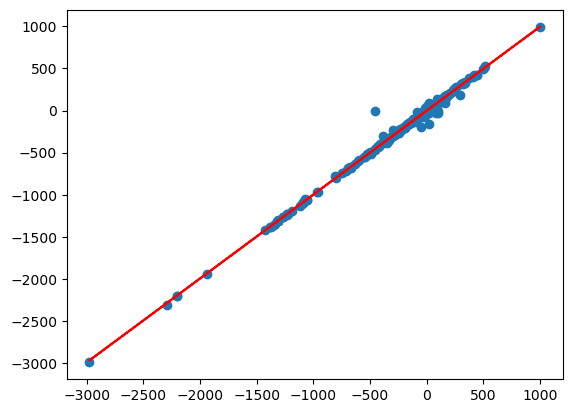

In [7]:
x = rapid_linear_reg(r, final_p, plot=True)

In [7]:
m = to_mol('C00001', cid_type='kegg')
m = to_mol('[H]O[H]', cid_type='smiles')
comp = Compound(m)

In [8]:
comp.condition['pH'] = 8.0

In [9]:
comp.atom_bag

{'O': 1, 'H': 2, 'charge': 0}

In [10]:
comp.standard_dGf_prime

array([-158.07564], dtype=float32)

In [6]:
comp.transformed_standard_dGf_prime

array([-158.07564], dtype=float32)

In [49]:
m = to_mol('C00001', cid_type='kegg')

In [50]:
comp = Compound(m)

In [51]:
comp.Smiles

'[H]O[H]'

In [27]:
RT = default_T * R

In [28]:
RT * np.log(10) * 1

5.704945844907011

In [19]:
p = pd.read_csv('./formation_dg_smiles.csv')

In [22]:
'[H+]' in p.Smiles.to_list()

False

In [23]:
p.index = p.Smiles

In [25]:
p.loc['[H]O[H]', :]

cid                  metanetx.chemical:MNXM2
name                                     H2O
standard_dg_prime                     -155.7
p_h                                      7.0
ionic_strength                          0.25
p_mg                                    14.0
temperature                           298.15
decompose                                  0
reference                     Alberty (2006)
remark                                   NaN
Smiles                               [H]O[H]
Name: [H]O[H], dtype: object